In [2]:
import torch


In [14]:
class Model(torch.nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.model = torch.nn.Conv2d(1, 2, 3)
    def forward(self, x):
        return self.model(x)

In [69]:
model = Model()
params = model.parameters()
lr = 0.2/8
optimizer = torch.optim.SGD(
        params, lr=lr, momentum=.9, weight_decay=1e-4)
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1)

In [70]:
lrs = []
for epoch in range(50):
    lr_scheduler1 = None
    if epoch == 0:
            warmup_factor = 1. / 1000
            warmup_iters = min(1000, 678 - 1)
            lr_scheduler1 = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
    for d in range(678):
        if lr_scheduler1 is not None:
            lr_scheduler1.step()
            lrs.append(lr_scheduler1.get_last_lr()[0])
        pass
    lr_scheduler.step()
    lrs.extend(lr_scheduler.get_last_lr()*678)
        

/home/adnen/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [71]:
import matplotlib.pyplot as plt

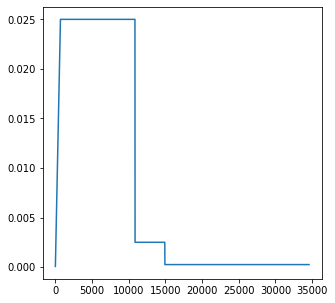

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(lrs)

In [129]:
SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = dict(
    mode='min',
    factor=0.5,
    patience=1,
    verbose=False, 
    threshold=0.0001,
    threshold_mode='abs',
    cooldown=0, 
    min_lr=1e-8,
    eps=1e-08
)
lr = 0.0002

In [130]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
] 

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = SchedulerClass(optimizer, **scheduler_params)

In [131]:
import numpy as np
lrs = []
for epoch in range(2):
    for i in range(678):
        scheduler.step(metrics=(687-i)**2)
        
        lrs.append(scheduler._last_lr[0])

        

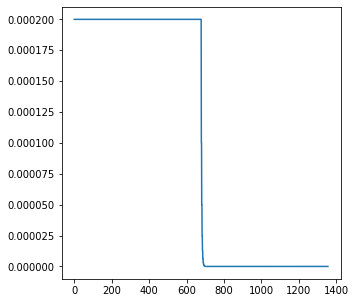

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(lrs)